In [138]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from sklearn.utils import shuffle
from sklearn.svm import SVC

period1 = pd.read_csv('dataset/Period1.csv')
period2 = pd.read_csv('dataset/Period2.csv')
test_data = pd.read_csv('dataset/TestData.csv')
period1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154836 entries, 0 to 154835
Data columns (total 3 columns):
year         154836 non-null int64
source id    154836 non-null int64
target id    154836 non-null int64
dtypes: int64(3)
memory usage: 3.5 MB


In [3]:
def find_unique_node(input_node_set1, input_node_set2):
    node_set = pd.concat([input_node_set1, input_node_set2], ignore_index=True)
    node_set_unique = node_set.loc[node_set.duplicated() == False]
    node_set_unique = node_set_unique.reset_index(drop=True)
    return node_set_unique


period1_node_unique = find_unique_node(period1['source id'], period1['target id'])
period2_node_unique = find_unique_node(period2['source id'], period2['target id'])
period_all_node_unique = find_unique_node(period1_node_unique, period2_node_unique)

# Format edge to newortkx type
period1_edge = [(period1.loc[i, 'source id'], period1.loc[i, 'target id']) for i in range(len(period1))]
period2_edge = [(period2.loc[i, 'source id'], period2.loc[i, 'target id']) for i in range(len(period2))]
period_all_edge = period1_edge + period2_edge

print('period_all ', 'node:', len(period_all_node_unique.values), 'edge:', len(period_all_edge))
print('period1 ', 'node:', len(period1_node_unique.values), 'edge:', len(period1_edge))
print('period2 ', 'node:', len(period2_node_unique.values), 'edge:', len(period2_edge))

period_all  node: 23237 edge: 253189
period1  node: 17028 edge: 154836
period2  node: 15565 edge: 98353


In [4]:
# Network generate (period1)
network_period1 = nx.Graph()
# Add nodes
network_period1.add_nodes_from(period_all_node_unique.values)
# Add edges
network_period1.add_edges_from(period1_edge)

print('node:', network_period1.number_of_nodes(), 'edge:', network_period1.number_of_edges())

node: 23237 edge: 154698


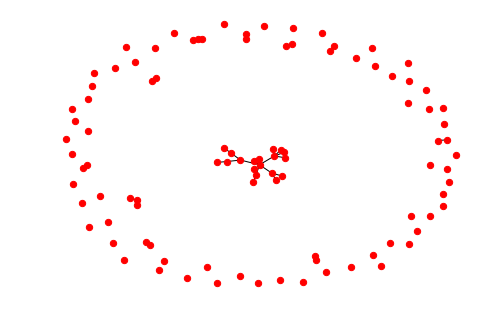

In [5]:
# network graph
sub_graph = network_period1.subgraph(list(period1_node_unique[0:100]))   # 原圖太大取前幾個邊出來畫
pos = nx.spring_layout(sub_graph)  # 圖的畫法
nx.draw(sub_graph, pos=pos, node_size=40, vim=0.0, vmax=1.0, node_color="red")

In [6]:
# Network generate (period_all)
network_all = nx.Graph()
# Add nodes
network_all.add_nodes_from(period_all_node_unique.values)
# Add edges
network_all.add_edges_from(period_all_edge)

print('node:', network_all.number_of_nodes(), 'edge:', network_all.number_of_edges())

node: 23237 edge: 252854


In [7]:
# check test data is in network
test_data_node_unique = find_unique_node(test_data['source id'], test_data['target id'])
test_data_in_network = pd.concat([period_all_node_unique, test_data_node_unique], ignore_index=True)
test_data_in_network = test_data_in_network.loc[test_data_in_network.duplicated() == True]
test_data_in_network = test_data_in_network.reset_index(drop=True)
print(test_data_in_network.head(5))

# Add test data node in network
network_all.add_nodes_from(test_data_node_unique.values)

0    208165
1    111208
2    202140
3    112113
4    108010
dtype: int64


In [59]:
# common neighbor score (neighbor = 1 best)
def common_neighbor(input_node_set1, input_node_set2): 
    source_neighbor = [n for n in network_all.neighbors(input_node_set1)]
    target_neighbor = [n for n in network_all.neighbors(input_node_set2)]
    intersection = list(set(source_neighbor) & set(target_neighbor))
    return len(intersection)

neighbor_score_list = []
for data_id, data in test_data.iterrows():
    neighbor_score_list.append(common_neighbor(data['source id'], data['target id']))
    
print(neighbor_score_list[709])

5


In [60]:
# Jaccard's cofficient
def jaccard_cofficient(input_node_set1, input_node_set2):
    cofficient = 0
    source_neighbor = [n for n in network_all.neighbors(input_node_set1)]
    target_neighbor = [n for n in network_all.neighbors(input_node_set2)]
    union = list(set(source_neighbor) | set(target_neighbor))
    intersection = list(set(source_neighbor) & set(target_neighbor))
    if len(union) == 0:
        return 0
    else:
        return (len(intersection) / len(union))
        
jaccard_score_list = []
    
for data_id, data in test_data.iterrows():
    jaccard_score_list.append(jaccard_cofficient(data['source id'], data['target id']))
        
# Networkx jaccard_coefficient function
# networkx_jaccard = []
# fucking_list = []

# for data_id, data in test_data.iterrows():
#     fucking_list.append(((data['source id'],data['target id'])))
    
# preds = nx.jaccard_coefficient(network_all, fucking_list)
# for u,v,p in preds:
#     networkx_jaccard.append(p)

# print(networkx_jaccard[709])
print(jaccard_score_list[709])

0.07692307692307693


In [63]:
#Adamic/Adar
def adamic_adar(input_node_set1, input_node_set2):
    adamic_score = 0
    source_neighbor = [n for n in network_all.neighbors(input_node_set1)]
    target_neighbor = [n for n in network_all.neighbors(input_node_set2)]
    intersection = list(set(source_neighbor) & set(target_neighbor))
    
    if len(intersection) == 0:
        return 0
    else:
        for v in intersection:
            adamic_score +=  1 / math.log(len([nv for nv in network_all.neighbors(v)]))
            
        return adamic_score
        
adamic_score_list = []

for data_id, data in test_data.iterrows():
     adamic_score_list.append(adamic_adar(data['source id'], data['target id']))   

# Networkx adamic_adar_index
# networkx_adamic_adar_index = []
# fucking_list = []

# for data_id, data in test_data.iterrows():
#     fucking_list.append(((data['source id'],data['target id'])))
    
# preds = nx.adamic_adar_index(network_all, fucking_list)
# for u,v,p in preds:
#     networkx_adamic_adar_index.append(p)

# print(networkx_adamic_adar_index[709])
print(adamic_score_list[709])

1.2312765119577431


In [117]:
# step 2
# find period1 complement graph (使用補圖的所有edge 當training data才對，不過我電腦跑不動)
# network_period1_complement = nx.complement(network_period1)
# print("complement down")
# complement_edge = network_period1_complement.edges()

# 直接使用period2裡面的當1，再從network_period1 亂數取幾個點，他們形成的補圖edge當0
# period1 subgraph
period1_node_shuffle = random.sample(list(period1_node_unique), 200)
sub_graph = network_period1.subgraph(period1_node_shuffle)
sub_graph_complement = nx.complement(sub_graph)
# pos = nx.spring_layout(sub_graph)  # 圖的畫法
# nx.draw(sub_graph_complement, pos=pos, node_size=40, vim=0.0, vmax=1.0, node_color="red")

# tag label
train_label = []
# 注意順序
for edge in period2_edge:
    train_label.append(1)
for edge in list(sub_graph_complement.edges()):
    train_label.append(0)   
    
train_data_edge = period2_edge + list(sub_graph_complement.edges())
train_data = pd.DataFrame(data={'edge': train_data_edge, 'label': train_label})

train_data = shuffle(train_data, random_state=42).reset_index(drop=True)
train_data.head()

,edge,label
0,"(9135, 9604129)",1
1,"(9412236, 9308100)",0
2,"(112029, 9310038)",1
3,"(104076, 7226)",1
4,"(9077, 9908008)",1


In [150]:
# train data feature
feature = []
for edge_id, edge in enumerate(train_data['edge'].values):
    cn = common_neighbor(edge[0], edge[1])
    jaccard = jaccard_cofficient(edge[0],edge[1])
    adamic = adamic_adar(edge[0], edge[1])
    feature.append([cn, jaccard, adamic])

train_data['feature'] = pd.Series(feature, index=train_data.index)
train_data.head(20)

,edge,label,feature
0,"(9135, 9604129)",1,"[28, 0.1686746987951807, 6.619855734900147]"
1,"(9412236, 9308100)",0,"[0, 0.0, 0]"
2,"(112029, 9310038)",1,"[0, 0.0, 0]"
3,"(104076, 7226)",1,"[5, 0.054945054945054944, 1.0327194627949408]"
4,"(9077, 9908008)",1,"[1, 0.058823529411764705, 0.28599966750267436]"
5,"(9509143, 9312168)",0,"[0, 0.0, 0]"
6,"(111165, 105097)",1,"[2, 0.023255813953488372, 0.5021952329947058]"
7,"(3163, 9802109)",1,"[8, 0.006488240064882401, 1.8942875237687427]"
8,"(10226, 4163)",1,"[15, 0.5172413793103449, 5.402063871588472]"
9,"(110115, 5247)",1,"[6, 0.043478260869565216, 1.423558256382131]"


In [173]:
#SVM gogo
import numpy as np
print(np.shape(train_data['feature'].tolist()))
clf = SVC()
clf.fit(train_data['feature'].tolist(), train_data['label'].tolist())


(118231, 3)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [187]:
# predict test data
test_feature = [[n, j, a] for n, j, a in zip(neighbor_score_list, jaccard_score_list, adamic_score_list)]

predict = clf.predict(test_feature)

In [188]:
# output predict
row = [i for i in range(1, 10001)]
label = predict

# for score in jaccard_score_list:
#     if score >= 1:
#         label.append(1)
#     else:
#         label.append(0)

data = {'target id': row, 'label': label}
predict = pd.DataFrame(data=data, columns=['target id', 'label'])
predict.to_csv("predict/svm1.csv", index=False)
